* Logical Steps to find all possible function call sequences triggered by a user event in Android apps *

Step 1. 
Parsing the Android Manifest File: Identifying all activities and their entry points.

Step 2. 
Parsing the UI Layout Files: Extracting all UI elements and their associated event handlers.

Step 3. 
Parsing the Java Source Code Files: Identifying all the method declaration and the subsequent method calls within (** Identifying Loops and Branches too, this time)
                                       
Step 4. 
Building a Call Graph: Building the Call Sequences analyzing the above set of results from (Step 1) manifest, (Step 2) layout and (Step 3) source code.

Pre-requisites:
1. Need py4j module which allows this python script to interact with Java Program via temp. server having JVM Machine

In [46]:
import os                            # Reading/writing files (We will be reading Manifest File, Layout file and Java File
import xml.etree.ElementTree as ET   # Parsing XML file as we will be dealing with manifest file and layout file
from pprint import pprint            # Prettifying the output instead of standard print() statment
from py4j.java_gateway import JavaGateway # This library allows Python script to interact iwth Java Programs
import graphviz
from graphviz import Digraph
from IPython.display import Image, display
from collections import OrderedDict

# Path of the directory. Here, I have used three main paths: Manifest Directory (XML File), Layouts Directory (XML files) and Source Directory (.Java files)
manifest_directory = "../Documents/Final/app/src/main/"
layouts_directory = "../Documents/Final/app/src/main/res/layout/"
source_directory = "../Documents/Final/app/src/main/java/com/example/afinal/"

# this is my custom print statment to output the result in readable way
def var_dump(name_of_variable, output):
    print(f"[{name_of_variable}]")
    print(type(output))
    pprint(output)
    print("======")

# Recursively gather all files with a specific extension
# @param: directory: Path of the directory
# @param: extension: Which file type need to be filtered from the given directory
def gather_files(directory, extension):
    files = []

    # root: The current directory path being explored
    # filenames: list of filenames in current directory
    # _ : we do not want 2nd item from os.walk (a tuple), so marked it as _
    for root, _, filenames in os.walk(directory):            #iterates over directories and sub-directories, r
        for filename in filenames:
            if filename.endswith(extension):                 # if mathches the given filename extension
                files.append(os.path.join(root, filename))   # full path to the file is constructed and is added to files[]
    return files

Step 1: Parsing Manifest File

In [47]:
#Parses the Android Manifest File to identify all 'activites'      
def parse_manifest_directory(manifest_directory):
    
    # Searches only manifest files (xml) and stores manifest_files
    manifest_files = gather_files(manifest_directory, '.xml')
    activities = [] # Empty list to hold the name of Activites found in Manifest file

    for manifest_file in manifest_files:     
        tree = ET.parse(manifest_file)                  # Parse the XML files and return ElementTree object
        root = tree.getroot()                           # Get the root elment of the prased SML tree. <manifest> element is generally the root element
        for activity in root.findall(".//activity"):    # finall() looks for the 'activity' elements in the tree. We are looking for activity
            activity_name = activity.get("{http://schemas.android.com/apk/res/android}name")  # Get the name of the activity (namespace is used here for retrieving name) 
            activities.append(activity_name)
    return activities

activities = parse_manifest_directory(manifest_directory)
# I am using my custom function to prettify (more readable) the output instead of plain print() 
var_dump("activities", activities)

[activities]
<class 'list'>
['.SettingsActivity', '.MainActivity']


Step 2: Parsing Layout Directory

In [48]:
# Parse layout files to get handlers
def parse_layouts_directory(layouts_directory):
    layout_files = gather_files(layouts_directory, '.xml')
    handlers = {}

    for layout_file in layout_files:
        tree = ET.parse(layout_file)
        root = tree.getroot()
        for element in root.iter():
            onClick = element.get("{http://schemas.android.com/apk/res/android}onClick") #retrieves the value of the attribute android:onClick attribute
            if onClick:
                element_id = element.get("{http://schemas.android.com/apk/res/android}id", 'unknown') # retrieve the value of the attribute ID of android:onClick attribute, if not assign it to 'unknown'
                handlers[element_id] = onClick # add the id of attribute and value of onClick in Key-Value pair in dictionary
    return handlers

handlers = parse_layouts_directory(layouts_directory)
var_dump("handlers", handlers)

[handlers]
<class 'dict'>
{'@+id/btnCountLoop': 'addNumbers',
 '@+id/btnDisplayText': 'handleText',
 '@+id/btnDoWhile': 'loopDoStatement',
 '@+id/btnForEach': 'forEachStatement',
 '@+id/btnIfStatement': 'displayGreater',
 '@+id/btnSettings': 'launchSettings',
 '@+id/btnSwitch': 'switchStatment',
 '@+id/button': 'goBack'}


Step 3: Parsing Java Source Code via JavaParser

In [50]:
# Start the Java gateway: Connection to a JVM
gateway = JavaGateway()

# Parse Java source files
def parse_java_source_code_directory(source_directory):

    source_files = gather_files(source_directory, '.java') #get the .Java files from the directory
    call_graph = {} #empty dictionary to later hold the call graph / sequence of event

    java_parser = gateway.entry_point #retrieves the entry point to the Java code from the Java gateway

    for source_file in source_files: #Parsing each java files found from the given directory
        try:
            method_calls_map = java_parser.parseJavaFile(source_file)  # this calls the method "parseJavaFile" in JavaParserService.java and should match!!
            
            # Following line is for testing purpose: To check what JavaParser has dumped to this python program
            # var_dump("method_calls_map", method_calls_map)

            call_graph[source_file] = {}

            # Reference only: 
            # key   : onCreate (String) 
            # value : Java object (py4j.java_collections.JavaList) [[[ Understanding this JavaObject was the most difficult part for me, always messed up when producing outpu ]]]
            for key, value in method_calls_map.items():
  
                call_graph[source_file][key] = [str(call) for call in value]  # Convert each MethodCall object to string using its toString method [This was tough solution for me]
                
        except Exception as e:
            print(f"Error parsing {source_file}: {e}")

    return call_graph

call_graph = parse_java_source_code_directory(source_directory)

# for testing purpose
# var_dump("call_graph", call_graph)

# Create a sequence dictionary combining *handlers - (Contains methods and its UI Trigger Name) and call graphs - (Contains Method Declaration and the subsequent mthodname within along with branching and loops) 
sequence = {}
for key, value in handlers.items():
    for source_file, methods in call_graph.items():
        if value in methods:
            sequence[key] = {value: methods[value]}

# Print the new dictionary
var_dump("sequence", sequence)

[sequence]
<class 'dict'>
{'@+id/btnCountLoop': {'addNumbers': ['findViewById (METHOD_CALL)',
                                      'setText (METHOD_CALL)',
                                      'valueOf (METHOD_CALL)',
                                      'doSomething (METHOD_CALL)',
                                      'doMoreinLoop (METHOD_CALL)',
                                      'setText (FOR_STMT)',
                                      'valueOf (FOR_STMT)',
                                      'doSomething (FOR_STMT)',
                                      'doMoreinLoop (FOR_STMT)']},
 '@+id/btnDisplayText': {'handleText': ['findViewById (METHOD_CALL)',
                                        'toString (METHOD_CALL)',
                                        'getText (METHOD_CALL)',
                                        'setText (METHOD_CALL)',
                                        'findViewById (METHOD_CALL)',
                                        'show (METHOD_CALL

Hot Fixes

In [51]:
## HOT FIXES =================
def remove_duplication(data):
  
    starting_point = 0
    delete_counter = 0
    
    found = 'no'
    i = 0

    while i <= len(data) - 1:  # Use '<' instead of '<=' to avoid IndexError
        
        key, value = list(data[i].items())[0]

        if value.endswith('FOR_STMT)') or value.endswith('SWITCH_STMT)') or value.endswith('DO_STMT)') or value.endswith('FOREACH_STMT)') or value.endswith('IF_STMT)'):

                starting_point = i # from this point, we will delete data
                found = 'yes'
            
                # Process the entire conditional block here
                while value.endswith('FOR_STMT)') or value.endswith('SWITCH_STMT)') or value.endswith('DO_STMT)') or value.endswith('FOREACH_STMT)') or value.endswith('IF_STMT)'):
                    delete_counter += 1
                    
                    i += 1
                    if i > len(data) - 1:
                        break
                    key, value = list(data[i].items())[0]
        else:
            pass

        if found == 'no':
            i += 1
        else:
            continue

    position = starting_point
    range_length = delete_counter

    result = data[:max(0, position - range_length)] + [data[position]] + data[position + 1:]
    return result


def fix_anomaly(data):
    # Extract the 1st, 2nd, and last positions
    first_position = data[0]   # First element
    second_position = data[1]  # Second element
    last_position = data[-1]   # Last element
    
    # Get the rest of the elements
    rest_list = data[2:-1]  # Elements from the 3rd to the second-last

    rest_list_treated = remove_duplication(rest_list)
    
    new_data = [first_position] + [second_position] + rest_list_treated + [last_position]
    return new_data


# ====== HOT FIX END 

Step 4: Prepare Data for Dot Language

In [52]:
def flatten_data(source_data):
    
    flow_data = OrderedDict(source_data)
    
    # Flatten the data
    flatten_data = []
    counter = 1
    for first_key, first_value in flow_data.items():
        
        flatten_data.append({str(counter): first_key}) # UI ID
        counter += 1
        
        for key,value in first_value.items():
            flatten_data.append({str(counter): key}) # Method Declaration
            counter += 1
            for item in value:
                flatten_data.append({str(counter): item})
                counter += 1

    counter += 1

    flatten_data.append({str(counter): 'STOP (METHOD_CALL)'})

    result = fix_anomaly(flatten_data)
    
    return result
    

# @pram: data is a list
def group_data(data):
    
    group_data = data
    return_data = []
    prev_type = 'METHOD_CALL'
    counter = 0          # to know the loop count: This also represent the list index number

    for item in group_data: #item are in key-value pair
        method_name = next(iter(item.values())) # get the name of method which is stored as value in key-value pair
        
        # method name should ends with loop or brnach statment but also the previous statment should be none of this type
        if (method_name.endswith('(SWITCH_STMT)') or method_name.endswith('(DO_STMT)') or method_name.endswith('(FOR_STMT)') or method_name.endswith('(FOREACH_STMT)') or method_name.endswith('(IF_STMT)')) and prev_type == 'METHOD_CALL':
            
            if method_name.endswith('(SWITCH_STMT)'): prev_type = 'SWITCH_STMT'
            if method_name.endswith('(DO_STMT)'): prev_type = 'DO_STMT'
            if method_name.endswith('(FOR_STMT)'): prev_type = 'FOR_STMT'
            if method_name.endswith('(FOREACH_STMT)'): prev_type = 'FOREACH_STMT'
            if method_name.endswith('(IF_STMT)'): prev_type = 'IF_STMT'

            # insert new list item marking the start of the loop or conditional block
            return_data.insert(counter, {str(counter) : prev_type+"_START"})
            counter += 1
            return_data.insert(counter, {str(counter) : method_name}) #also need to inser the current statment after inserting marker
            
        elif method_name.endswith('(METHOD_CALL)'):

            if prev_type != 'METHOD_CALL': 
                return_data.insert(counter, {str(counter) : prev_type+'_END'})
                counter += 1

            return_data.insert(counter, {str(counter) : method_name})
            prev_type = 'METHOD_CALL'
            
        else:
            return_data.insert(counter, {str(counter) : method_name})

        counter += 1

    return return_data

Generate Flow Graph using GraphViz module

In [54]:
# @param: data: List
def generate_flow_graph(data):

    # Initialize a Graphviz Digraph
    dot = graphviz.Digraph()
    block_ids = []
    i = 0
    prev_node_id = ''
    loop_node = ''
    
    while i <= len(data) - 1:
   
        key_from, label_from = list(data[i].items())[0]
 
        if i == 0:                             # Path1: will always be starting node [UI ID]
            dot.node(key_from, label_from)
            prev_node_id = key_from
        elif i == 1:                           # Path 2: will always be method declaration that connects to previous node.
            dot.node(key_from, label_from)
            dot.edge(prev_node_id, key_from)
            prev_node_id = key_from
        else:                                  # Path 3: other than 1st and 2nd item in list (could be anything)

            # Handles Branching and Decision Block
            if label_from == 'SWITCH_STMT_START' or label_from == 'IF_STMT_START':
                #create the conditional statement node here (Diamond)
                dot.node(key_from, 'Conditional Statement', shape='diamond')
                dot.edge(prev_node_id, key_from)
                prev_node_id = key_from
                i += 1
                
                key_from, label_from = list(data[i].items())[0]

                # Process the entire conditional block here
                while label_from.endswith('(SWITCH_STMT)') or label_from.endswith('(IF_STMT)'):
                    
                    dot.node(key_from, label_from)
                    dot.edge(prev_node_id, key_from)
                    # here, no need to re-assign prev_node_id, instead need to recrord all blocks ids in List
                    block_ids.append(key_from)
                    
                    i += 1
                    key_from, label_from = list(data[i].items())[0]

            # Handles Loops Block 
            elif label_from == 'FOR_STMT_START' or label_from == 'DO_STMT_START' or label_from == 'FOREACH_STMT_START':

                dot.node(key_from, 'Conditional Statement', shape = 'diamond')
                dot.edge(prev_node_id, key_from)
                prev_node_id = key_from
                loop_node = key_from

            # Deals with closing loop ends
            elif label_from.endswith('FOR_STMT_END') or label_from.endswith('DO_STMT_END') or label_from.endswith('FOREACH_STMT_END'):

                dot.node(key_from, 'Loop End', shape = 'circle', style='filled', fillcolor='black')
                dot.edge(prev_node_id, key_from)
                dot.edge(key_from, loop_node)
                prev_node_id = key_from
                loop_node = ''
                    
            elif label_from.endswith('SWITCH_STMT_END') or label_from.endswith('IF_STMT_END'):

                dot.node(key_from, 'Merging', shape = 'circle', style='filled', fillcolor='black')

                #creating multiple edges that connects to this merging point
                for block_id in block_ids:
                    dot.edge(block_id, key_from)

                block_ids.clear() # clear the list
                prev_node_id = key_from
            else:
                dot.node(key_from, label_from)
                dot.edge(prev_node_id, key_from)
                prev_node_id = key_from

        if len(block_ids) == 0: #List is empty
            i += 1
        else:
            continue
        
    display(dot)
  

Finally Call the method to plot Flow Graph

[data]
<class 'dict'>
{'@+id/button': {'goBack': ['startActivity (METHOD_CALL)']}}
[flat_data]
<class 'list'>
[{'1': '@+id/button'},
 {'2': 'goBack'},
 {'3': 'startActivity (METHOD_CALL)'},
 {'5': 'STOP (METHOD_CALL)'}]
[grouped_data]
<class 'list'>
[{'0': '@+id/button'},
 {'1': 'goBack'},
 {'2': 'startActivity (METHOD_CALL)'},
 {'3': 'STOP (METHOD_CALL)'}]


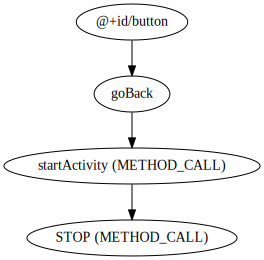

[data]
<class 'dict'>
{'@+id/btnSettings': {'launchSettings': ['toString (METHOD_CALL)',
                                         'getText (METHOD_CALL)',
                                         'findViewById (METHOD_CALL)',
                                         'putExtra (METHOD_CALL)',
                                         'startActivity (METHOD_CALL)']}}
[flat_data]
<class 'list'>
[{'1': '@+id/btnSettings'},
 {'2': 'launchSettings'},
 {'3': 'toString (METHOD_CALL)'},
 {'4': 'getText (METHOD_CALL)'},
 {'5': 'findViewById (METHOD_CALL)'},
 {'6': 'putExtra (METHOD_CALL)'},
 {'7': 'startActivity (METHOD_CALL)'},
 {'9': 'STOP (METHOD_CALL)'}]
[grouped_data]
<class 'list'>
[{'0': '@+id/btnSettings'},
 {'1': 'launchSettings'},
 {'2': 'toString (METHOD_CALL)'},
 {'3': 'getText (METHOD_CALL)'},
 {'4': 'findViewById (METHOD_CALL)'},
 {'5': 'putExtra (METHOD_CALL)'},
 {'6': 'startActivity (METHOD_CALL)'},
 {'7': 'STOP (METHOD_CALL)'}]


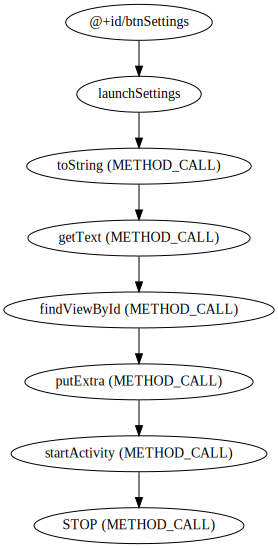

[data]
<class 'dict'>
{'@+id/btnDisplayText': {'handleText': ['findViewById (METHOD_CALL)',
                                        'toString (METHOD_CALL)',
                                        'getText (METHOD_CALL)',
                                        'setText (METHOD_CALL)',
                                        'findViewById (METHOD_CALL)',
                                        'show (METHOD_CALL)',
                                        'makeText (METHOD_CALL)']}}
[flat_data]
<class 'list'>
[{'1': '@+id/btnDisplayText'},
 {'2': 'handleText'},
 {'3': 'findViewById (METHOD_CALL)'},
 {'4': 'toString (METHOD_CALL)'},
 {'5': 'getText (METHOD_CALL)'},
 {'6': 'setText (METHOD_CALL)'},
 {'7': 'findViewById (METHOD_CALL)'},
 {'8': 'show (METHOD_CALL)'},
 {'9': 'makeText (METHOD_CALL)'},
 {'11': 'STOP (METHOD_CALL)'}]
[grouped_data]
<class 'list'>
[{'0': '@+id/btnDisplayText'},
 {'1': 'handleText'},
 {'2': 'findViewById (METHOD_CALL)'},
 {'3': 'toString (METHOD_CALL)'},
 {'4':

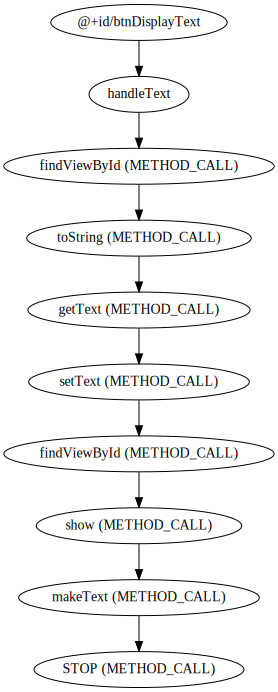

[data]
<class 'dict'>
{'@+id/btnCountLoop': {'addNumbers': ['findViewById (METHOD_CALL)',
                                      'setText (METHOD_CALL)',
                                      'valueOf (METHOD_CALL)',
                                      'doSomething (METHOD_CALL)',
                                      'doMoreinLoop (METHOD_CALL)',
                                      'setText (FOR_STMT)',
                                      'valueOf (FOR_STMT)',
                                      'doSomething (FOR_STMT)',
                                      'doMoreinLoop (FOR_STMT)']}}
[flat_data]
<class 'list'>
[{'1': '@+id/btnCountLoop'},
 {'2': 'addNumbers'},
 {'3': 'findViewById (METHOD_CALL)'},
 {'8': 'setText (FOR_STMT)'},
 {'9': 'valueOf (FOR_STMT)'},
 {'10': 'doSomething (FOR_STMT)'},
 {'11': 'doMoreinLoop (FOR_STMT)'},
 {'13': 'STOP (METHOD_CALL)'}]
[grouped_data]
<class 'list'>
[{'0': '@+id/btnCountLoop'},
 {'1': 'addNumbers'},
 {'2': 'findViewById (METHOD_CALL)'},
 

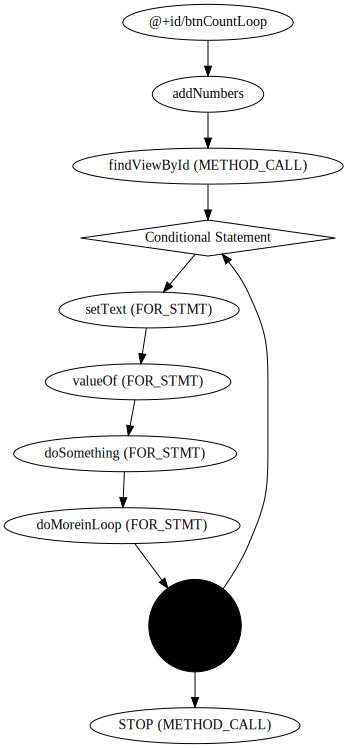

[data]
<class 'dict'>
{'@+id/btnIfStatement': {'displayGreater': ['findViewById (METHOD_CALL)',
                                            'setText (METHOD_CALL)',
                                            'setText (METHOD_CALL)',
                                            'setText (IF_STMT)',
                                            'setText (IF_STMT)']}}
[flat_data]
<class 'list'>
[{'1': '@+id/btnIfStatement'},
 {'2': 'displayGreater'},
 {'3': 'findViewById (METHOD_CALL)'},
 {'6': 'setText (IF_STMT)'},
 {'7': 'setText (IF_STMT)'},
 {'9': 'STOP (METHOD_CALL)'}]
[grouped_data]
<class 'list'>
[{'0': '@+id/btnIfStatement'},
 {'1': 'displayGreater'},
 {'2': 'findViewById (METHOD_CALL)'},
 {'3': 'IF_STMT_START'},
 {'4': 'setText (IF_STMT)'},
 {'5': 'setText (IF_STMT)'},
 {'6': 'IF_STMT_END'},
 {'7': 'STOP (METHOD_CALL)'}]


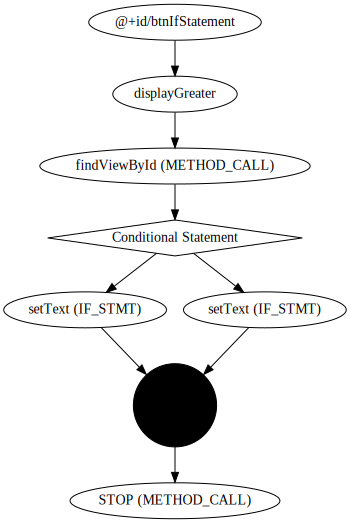

[data]
<class 'dict'>
{'@+id/btnDoWhile': {'loopDoStatement': ['findViewById (METHOD_CALL)',
                                         'setText (METHOD_CALL)',
                                         'doSomething (METHOD_CALL)',
                                         'doMoreinLoop (METHOD_CALL)',
                                         'setText (DO_STMT)',
                                         'doSomething (DO_STMT)',
                                         'doMoreinLoop (DO_STMT)']}}
[flat_data]
<class 'list'>
[{'1': '@+id/btnDoWhile'},
 {'2': 'loopDoStatement'},
 {'3': 'findViewById (METHOD_CALL)'},
 {'7': 'setText (DO_STMT)'},
 {'8': 'doSomething (DO_STMT)'},
 {'9': 'doMoreinLoop (DO_STMT)'},
 {'11': 'STOP (METHOD_CALL)'}]
[grouped_data]
<class 'list'>
[{'0': '@+id/btnDoWhile'},
 {'1': 'loopDoStatement'},
 {'2': 'findViewById (METHOD_CALL)'},
 {'3': 'DO_STMT_START'},
 {'4': 'setText (DO_STMT)'},
 {'5': 'doSomething (DO_STMT)'},
 {'6': 'doMoreinLoop (DO_STMT)'},
 {'7': 'DO_STM

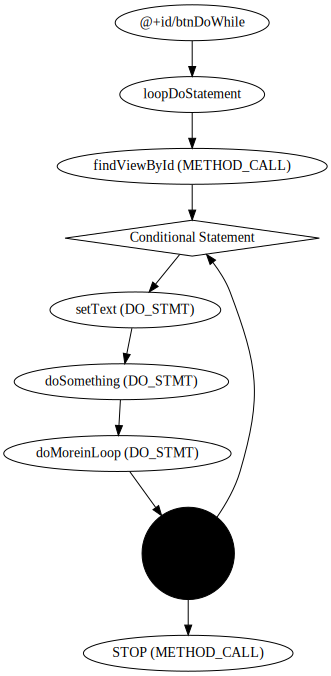

[data]
<class 'dict'>
{'@+id/btnForEach': {'forEachStatement': ['findViewById (METHOD_CALL)',
                                          'setText (METHOD_CALL)',
                                          'doSomething (METHOD_CALL)',
                                          'doMoreinLoop (METHOD_CALL)',
                                          'setText (FOREACH_STMT)',
                                          'doSomething (FOREACH_STMT)',
                                          'doMoreinLoop (FOREACH_STMT)']}}
[flat_data]
<class 'list'>
[{'1': '@+id/btnForEach'},
 {'2': 'forEachStatement'},
 {'3': 'findViewById (METHOD_CALL)'},
 {'7': 'setText (FOREACH_STMT)'},
 {'8': 'doSomething (FOREACH_STMT)'},
 {'9': 'doMoreinLoop (FOREACH_STMT)'},
 {'11': 'STOP (METHOD_CALL)'}]
[grouped_data]
<class 'list'>
[{'0': '@+id/btnForEach'},
 {'1': 'forEachStatement'},
 {'2': 'findViewById (METHOD_CALL)'},
 {'3': 'FOREACH_STMT_START'},
 {'4': 'setText (FOREACH_STMT)'},
 {'5': 'doSomething (FOREACH_STM

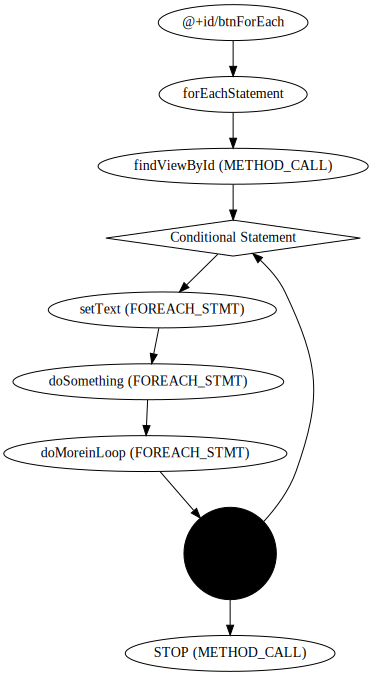

[data]
<class 'dict'>
{'@+id/btnSwitch': {'switchStatment': ['findViewById (METHOD_CALL)',
                                       'setText (METHOD_CALL)',
                                       'setText (METHOD_CALL)',
                                       'setText (METHOD_CALL)',
                                       'setText (METHOD_CALL)',
                                       'setText (SWITCH_STMT)',
                                       'setText (SWITCH_STMT)',
                                       'setText (SWITCH_STMT)',
                                       'setText (SWITCH_STMT)']}}
[flat_data]
<class 'list'>
[{'1': '@+id/btnSwitch'},
 {'2': 'switchStatment'},
 {'3': 'findViewById (METHOD_CALL)'},
 {'8': 'setText (SWITCH_STMT)'},
 {'9': 'setText (SWITCH_STMT)'},
 {'10': 'setText (SWITCH_STMT)'},
 {'11': 'setText (SWITCH_STMT)'},
 {'13': 'STOP (METHOD_CALL)'}]
[grouped_data]
<class 'list'>
[{'0': '@+id/btnSwitch'},
 {'1': 'switchStatment'},
 {'2': 'findViewById (METHOD_CA

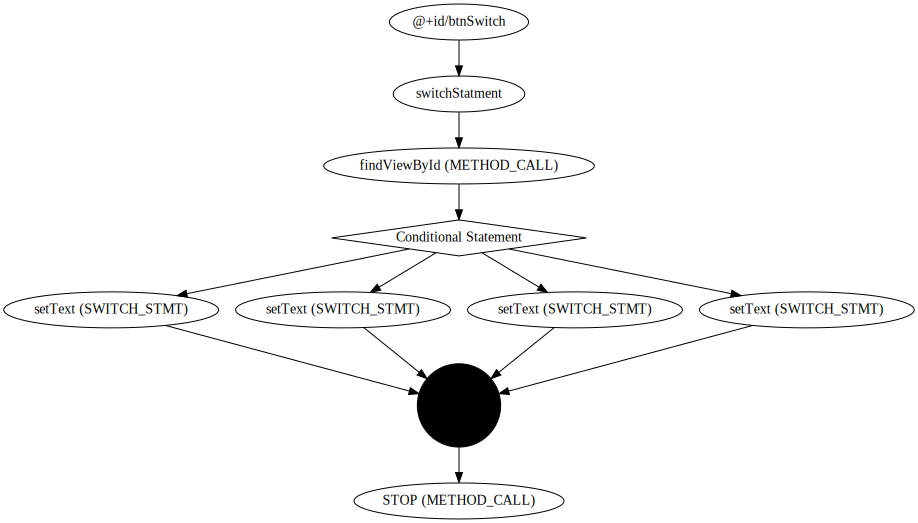

In [55]:
      
for key,value in sequence.items():
    data = {}
    data[key] = value

    var_dump('data', data)
    
    flat_data = flatten_data(data)
    var_dump('flat_data', flat_data)
    
    grouped_data = group_data(flat_data)
    var_dump('grouped_data', grouped_data)
    
    generate_flow_graph(grouped_data)
    